In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from jours_feries_france import JoursFeries
import matplotlib.pyplot as plt

In [2]:
holidays_2020_2021 = (
    list(JoursFeries.for_year(2020).values()) +
    list(JoursFeries.for_year(2021).values())
)

holidays_2020_2021 = pd.to_datetime(holidays_2020_2021)

In [3]:
def encode_dates(X):
    """
    Encode date information from the 'date' column.
    Adds year, month, day, weekday, hour, holiday, and weekend indicators.
    """
    lockdown_periods = [
        ("2020-03-17", "2020-05-11"),
        ("2020-10-30", "2020-12-14"),
        ("2021-04-03", "2021-06-30"),
    ]
    
    lockdown_ranges = [
        (pd.to_datetime(start), pd.to_datetime(end)) for start, end in lockdown_periods
    ]
    
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X["holiday"] = X["date"].isin(holidays_2020_2021).astype(int)
    X["weekend"] = (X["date"].dt.dayofweek > 4).astype(int)
    X["lockdown"] = X["date"].apply(
        lambda d: any(start <= d <= end for start, end in lockdown_ranges)
    ).astype(int)
    X['is_peak'] = X['hour'].apply(lambda x: 1 if (6 <= x < 9 or 16 <= x < 19) else 0)

    X['sin_hour'] = np.sin(2 * np.pi * X['hour'] / 24)
    X['cos_hour'] = np.cos(2 * np.pi * X['hour'] / 24)
    
    return X.drop(columns=['date', 'hour'])

In [4]:
def engineer_weather_features(data):
    # 1. Categorical Buckets
    data['rain_category'] = pd.cut(
        data['rr1'], bins=[-1, 0, 2, 10, float('inf')],
        labels=['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain']
    )
    
    data['snow_category'] = pd.cut(
        data['ht_neige'], bins=[-1, 0, 0.01, 0.05, float('inf')],
        labels=['No Snow', 'Light Snow', 'Moderate Snow', 'Heavy Snow']
    )
    
    data['is_hot_day'] = (data['t'] > 300).astype(int)  # Assuming temperature in Kelvin
    data['is_cold_day'] = (data['t'] < 283).astype(int)
    data['high_wind'] = (data['ff'] > 5).astype(int)
    
    # 3. Interaction Features
    data['rain_with_wind'] = data['rr1'] * data['ff']
    
    data['rolling_rain'] = data['rr1'].rolling(window=3, min_periods=1).sum()
    
    return data

In [5]:
data = pd.read_parquet(Path("data") / "train.parquet")

important_columns = ["date", "pres", "ff", "t", "u", "vv", "n", "ht_neige", "rr1"]
weather_data = pd.read_csv("./external_data/external_data.csv", usecols=important_columns)

In [6]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
weather_data = weather_data.dropna(axis=1, how="all")
weather_data.set_index("date", inplace=True)
weather_data = weather_data[~weather_data.index.duplicated(keep="first")]
weather_data_interpolated = weather_data.resample("h").interpolate(method="linear")

In [8]:
merged_data = data.merge(weather_data_interpolated, on="date", how="left")

X = merged_data[["counter_name", "site_name", "date", "longitude", "latitude", "ff", "t", "u", "vv", "n", "pres", "ht_neige", "rr1"]]
y = merged_data["log_bike_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply date encoding

X_train_encoded2 = encode_dates(X_train)
X_test_encoded2 = encode_dates(X_test)

X_train_encoded3 = engineer_weather_features(X_train_encoded2)
X_test_encoded3 = engineer_weather_features(X_test_encoded2)

# Column transformer for preprocessing
categorical_features = ["counter_name", "site_name", "rain_category", "snow_category"]
numerical_features = list(X_train_encoded3.drop(columns=categorical_features).columns)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [9]:
ridge = Ridge()
catboost = CatBoostRegressor(verbose=0, random_state=42)
random_forest = RandomForestRegressor(random_state=42)
xgboost = XGBRegressor(random_state=42)

ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", ridge)
])

catboost_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", catboost)
])

random_forest_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", random_forest)
])

xgboost_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgboost)
])

pipelines = {
    "Ridge": ridge_pipeline,
    "CatBoost": catboost_pipeline,
#   "RandomForest": random_forest_pipeline,
    "XGBoost": xgboost_pipeline
}

In [10]:
rmse_scores = {}

print("\nBaseline Model Performance:")
for name, pipeline in pipelines.items():
    # Fit model
    pipeline.fit(X_train_encoded3, y_train)
    
    # Predict and calculate RMSE
    y_pred = pipeline.predict(X_test_encoded3)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_scores[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")


Baseline Model Performance:
Ridge RMSE: 0.8867
CatBoost RMSE: 0.3979
XGBoost RMSE: 0.4314


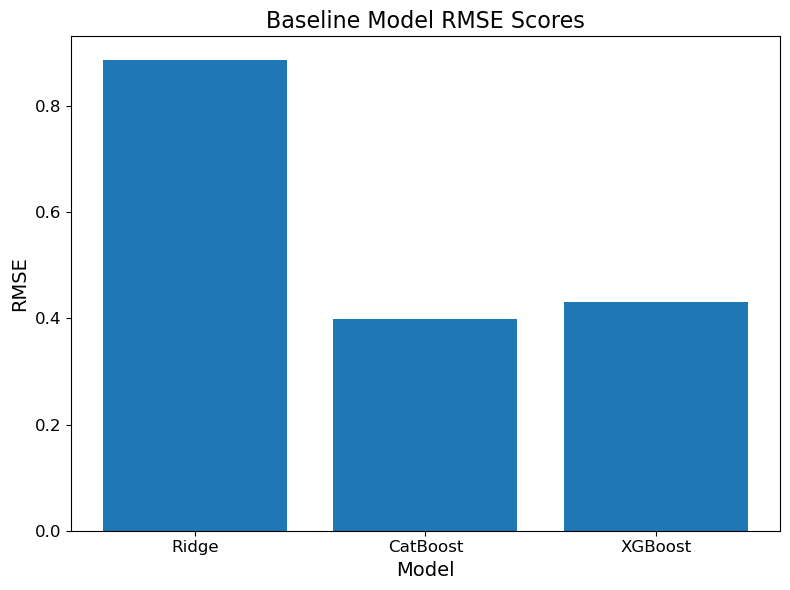

In [11]:
# Plot the RMSE scores
plt.figure(figsize=(8, 6))
plt.bar(rmse_scores.keys(), rmse_scores.values())
plt.title("Baseline Model RMSE Scores", fontsize=16)
plt.ylabel("RMSE", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()